In [34]:
from pathlib import Path
import string
from collections import defaultdict
import numpy as np
import pandas as pd
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from sklearn.metrics import silhouette_score
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer, WordNetLemmatizer
from nltk import pos_tag, word_tokenize
from sentence_transformers import SentenceTransformer

nltk.download('punkt', quiet=True)
nltk.download('stopwords', quiet=True)
nltk.download('wordnet', quiet=True)
nltk.download('averaged_perceptron_tagger_eng')
nltk.download('punkt_tab')

STOP_WORDS = set(stopwords.words('english'))
PUNCT_TABLE = str.maketrans('', '', string.punctuation)


[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger_eng.zip.
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


In [40]:
def get_wordnet_pos(tag: str) -> str:
    tag = tag[0].upper()
    return {
        'J': 'a',
        'N': 'n',
        'V': 'v',
        'R': 'r',
    }.get(tag, 'n')


def preprocess(text: str, method: str = 'lemma', ngram: int = 1) -> str:
    tokens = [t.lower() for t in word_tokenize(text)]
    tokens = [t.translate(PUNCT_TABLE) for t in tokens]
    tokens = [t for t in tokens if t and t not in STOP_WORDS]
    if method == 'stem':
        stemmer = PorterStemmer()
        tokens = [stemmer.stem(t) for t in tokens]
    else:
        lemm = WordNetLemmatizer()
        pos_tags = pos_tag(tokens)
        tokens = [lemm.lemmatize(t, get_wordnet_pos(p)) for t, p in pos_tags]
    if ngram > 1:
        grams = [' '.join(tokens[i:i + ngram]) for i in range(len(tokens) - ngram + 1)]
    else:
        grams = tokens
    return ' '.join(grams)


def load_lyrics(csv_path) -> pd.Series:
    df = pd.read_csv(csv_path)
    if 'Lyric' not in df.columns:
        raise ValueError('Expected column "Lyric" in dataset')
    df = df.dropna(subset=['Lyric'])
    return df['Lyric']


def embed_lyrics(lyrics: list[str], model_name: str) -> np.ndarray:
    model = SentenceTransformer(model_name)
    embeddings = model.encode(lyrics, show_progress_bar=True)
    return np.array(embeddings)


def run_kmeans(data: np.ndarray, k: int):
    km = KMeans(n_clusters=k, random_state=42)
    labels = km.fit_predict(data)
    score = silhouette_score(data, labels)
    return labels, score


def run_dbscan(data: np.ndarray, eps: float, min_samples: int):
    db = DBSCAN(eps=eps, min_samples=min_samples)
    labels = db.fit_predict(data)
    if len(set(labels)) > 1 and -1 not in set(labels):
        score = silhouette_score(data, labels)
    else:
        score = float('nan')
    return labels, score


def run_agglomerative(data: np.ndarray, k: int):
    agg = AgglomerativeClustering(n_clusters=k, linkage='ward')
    labels = agg.fit_predict(data)
    score = silhouette_score(data, labels)
    return labels, score


def elbow_plot(data: np.ndarray, k_range: range):
    sse = []
    for k in k_range:
        km = KMeans(n_clusters=k, random_state=42)
        km.fit(data)
        sse.append(km.inertia_)
    plt.figure()
    plt.plot(list(k_range), sse, marker='o')
    plt.xlabel('Number of clusters (k)')
    plt.ylabel('SSE')
    plt.title('Elbow Method for K-Means')
    plt.show()
    plt.close()


def scatter_plot(data: np.ndarray, labels: np.ndarray):
    pca = PCA(n_components=2, random_state=42)
    coords = pca.fit_transform(data)
    plt.figure()
    num_labels = len(set(labels))
    for lab in set(labels):
        idx = labels == lab
        plt.scatter(coords[idx, 0], coords[idx, 1], label=str(lab), s=10)
    if num_labels <= 10:
        plt.legend()
    plt.xlabel('PC1')
    plt.ylabel('PC2')
    plt.tight_layout()
    plt.show()
    plt.close()


def summarise_dataset(lyrics: pd.Series) -> dict:
    lengths = lyrics.str.split().str.len()
    return {
        'num_songs': len(lyrics),
        'min_length': lengths.min(),
        'max_length': lengths.max(),
        'avg_length': lengths.mean(),
    }

In [36]:
csv_path = 'musicLyrics.csv'
model_name = 'all-MiniLM-L6-v2'
preprocess_methods = ['lemma', 'stem']
ngram_sizes = [1, 2]

In [37]:
lyrics = load_lyrics(csv_path)
processed_sets = {}
for pm in preprocess_methods:
    for n in ngram_sizes:
        key = f'{pm}_n{n}'
        processed_sets[key] = [
            preprocess(t, method=pm, ngram=n)
            for t in tqdm(lyrics, desc=f'Preprocess {key}')
        ]

Preprocess lemma_n1:   0%|          | 0/2999 [00:00<?, ?it/s]

Preprocess lemma_n2:   0%|          | 0/2999 [00:00<?, ?it/s]

Preprocess stem_n1:   0%|          | 0/2999 [00:00<?, ?it/s]

Preprocess stem_n2:   0%|          | 0/2999 [00:00<?, ?it/s]

In [38]:
embedding_sets = {key: embed_lyrics(texts, model_name)
                  for key, texts in processed_sets.items()}


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:104: UserWarning: 
Error while fetching `HF_TOKEN` secret value from your vault: 'Requesting secret HF_TOKEN timed out. Secrets can only be fetched when running from the Colab UI.'.
You are not authenticated with the Hugging Face Hub in this notebook.
If the error persists, please let us know by opening an issue on GitHub (https://github.com/huggingface/huggingface_hub/issues/new).
  warnings.warn(


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Batches:   0%|          | 0/94 [00:00<?, ?it/s]

Batches:   0%|          | 0/94 [00:00<?, ?it/s]

Batches:   0%|          | 0/94 [00:00<?, ?it/s]

Batches:   0%|          | 0/94 [00:00<?, ?it/s]

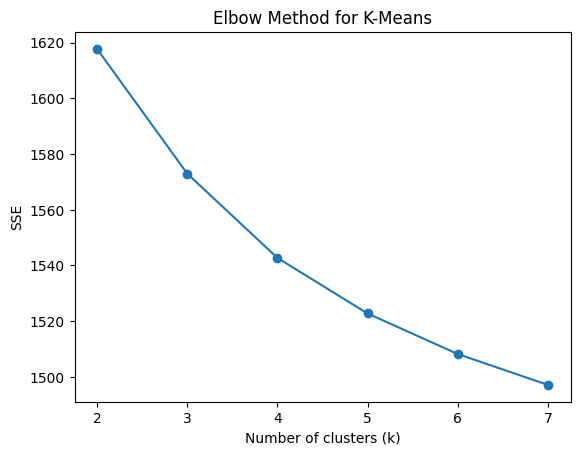

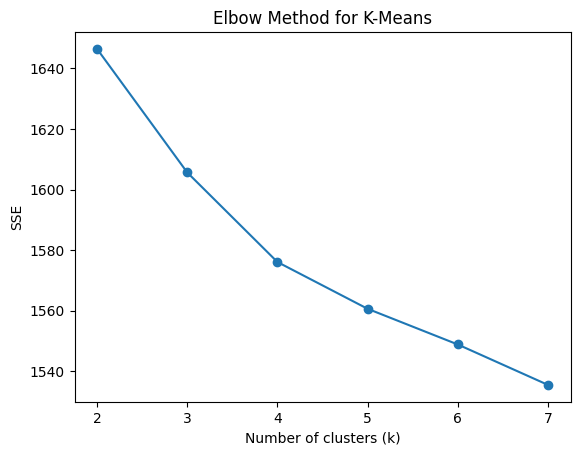

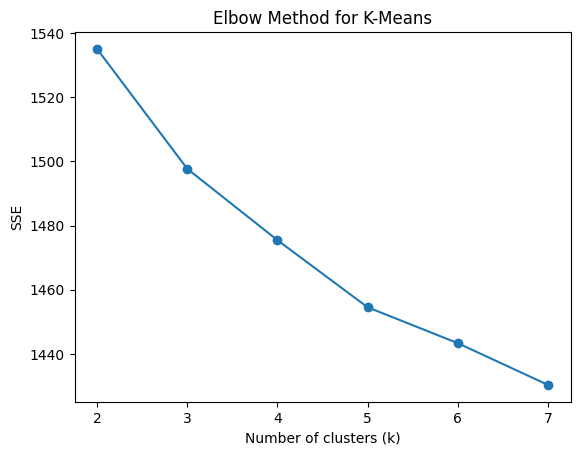

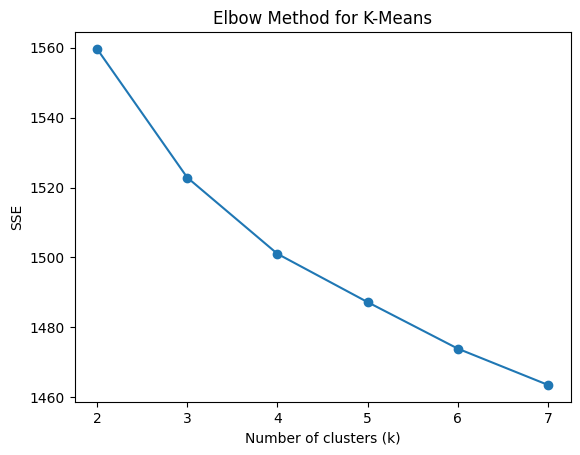

In [41]:
for name, emb in embedding_sets.items():
    elbow_plot(emb, range(2, 8))


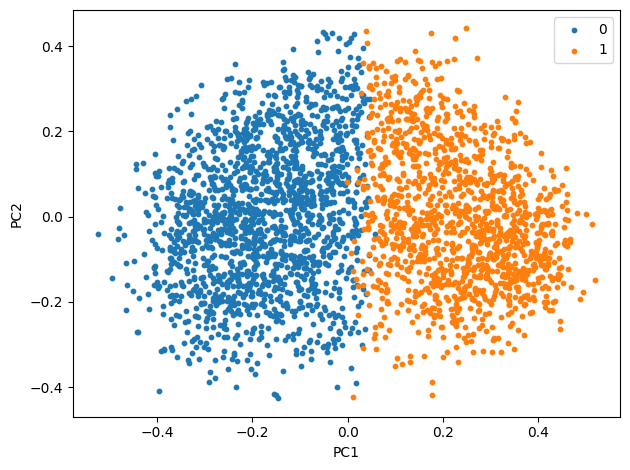

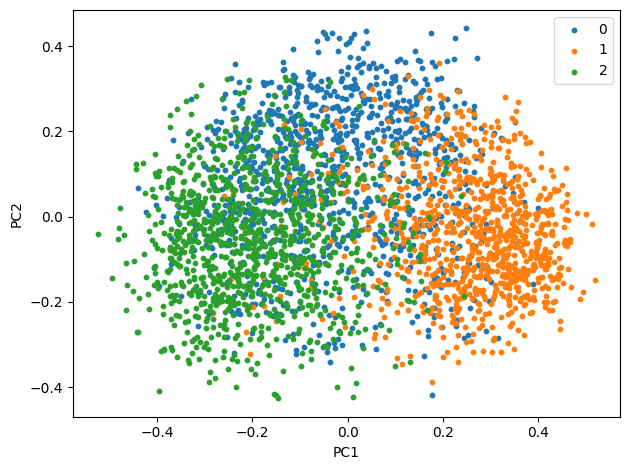

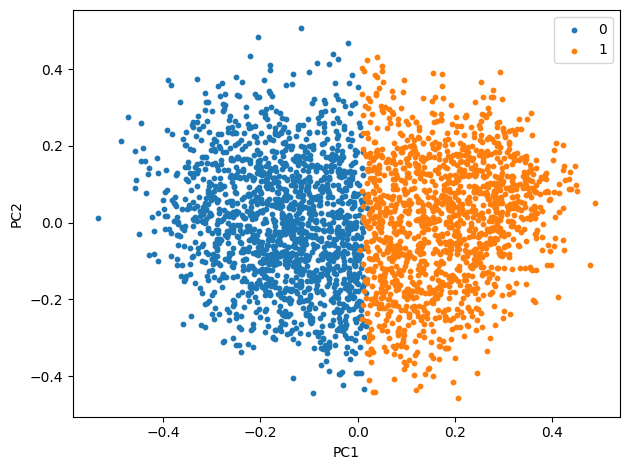

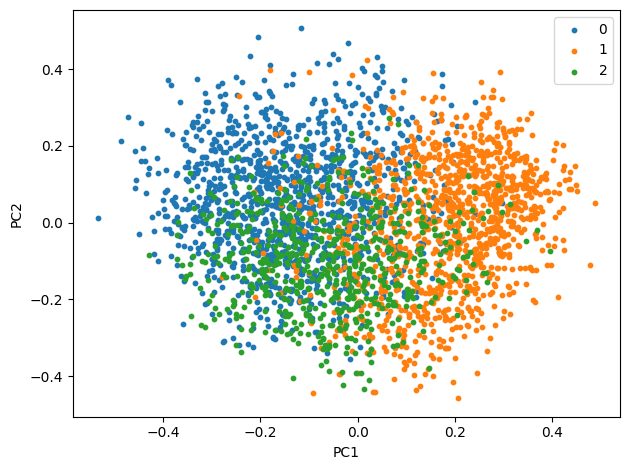

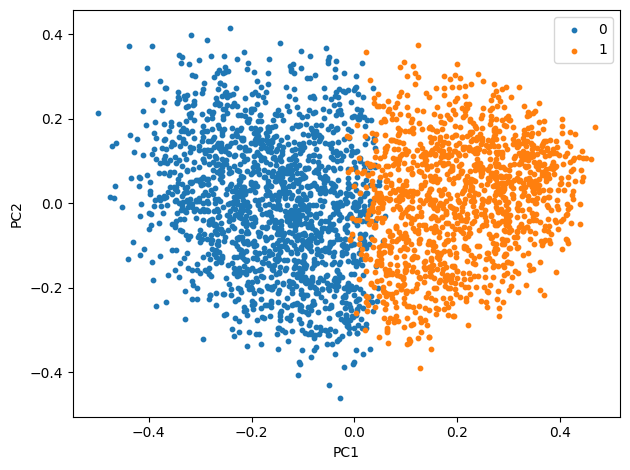

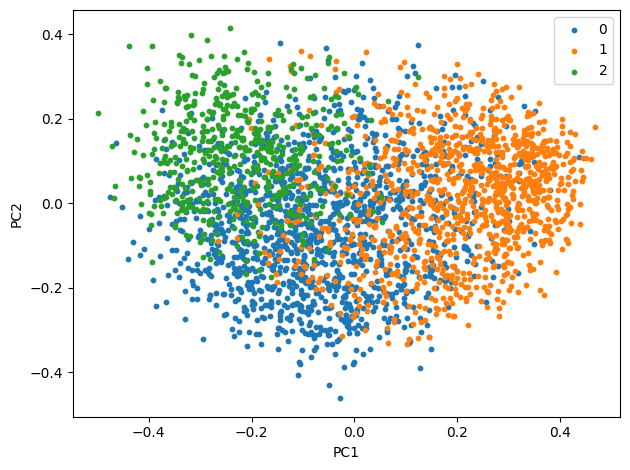

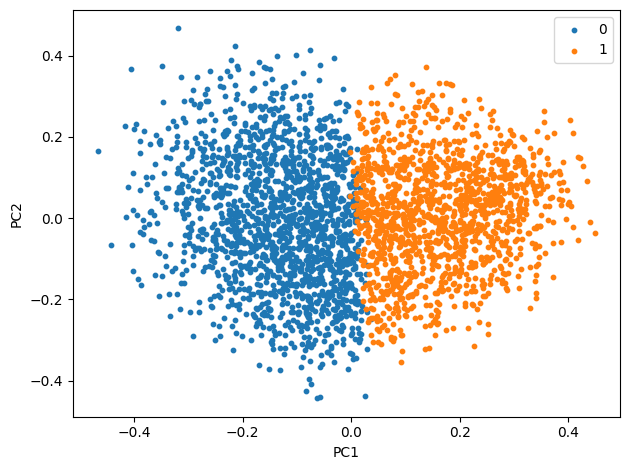

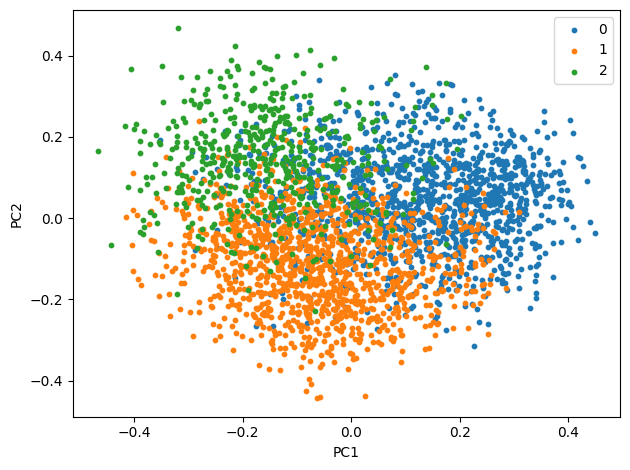

In [42]:
results = {}
label_sets = {}
for name, emb in embedding_sets.items():
    k_labels, k_score = run_kmeans(emb, k=2)
    scatter_plot(emb, k_labels)
    db_labels, db_score = run_dbscan(emb, eps=0.5, min_samples=5)
    if not np.isnan(db_score):
        scatter_plot(emb, db_labels)
    ag_labels, ag_score = run_agglomerative(emb, k=3)
    scatter_plot(emb, ag_labels)
    results[name] = (k_score, db_score, ag_score)
    label_sets[name] = k_labels


In [43]:
for name, scores in results.items():
    k_score, db_score, ag_score = scores
    print(f'\n{name}')
    print('Silhouette Scores:')
    print(f'  K-Means (k=2): {k_score:.3f}')
    print(f'  DBSCAN: {db_score:.3f}')
    print(f'  Agglomerative (k=3): {ag_score:.3f}')
    examples = defaultdict(list)
    for lyric, lab in zip(lyrics, label_sets[name]):
        if len(examples[lab]) < 2:
            examples[lab].append(lyric[:120] + '...')
        if all(len(v) >= 2 for v in examples.values()):
            break
    print('Cluster Examples (K-Means):')
    for lab, exs in examples.items():
        print(f'Cluster {lab}')
        for ex in exs:
            print(f'  - {ex}')


lemma_n1
Silhouette Scores:
  K-Means (k=2): 0.065
  DBSCAN: nan
  Agglomerative (k=3): 0.036
Cluster Examples (K-Means):
Cluster 0
  - Cryptic psalms Amidst the howling winds A scorching source of agonizing bliss Beneath its veil Mysteries of a life beyon...
  - Im sleeping tonight with all the wolves Were dreaming of life thats better planned As long as the wind that falls isnt l...

lemma_n2
Silhouette Scores:
  K-Means (k=2): 0.047
  DBSCAN: nan
  Agglomerative (k=3): 0.023
Cluster Examples (K-Means):
Cluster 0
  - Cryptic psalms Amidst the howling winds A scorching source of agonizing bliss Beneath its veil Mysteries of a life beyon...
  - Im sleeping tonight with all the wolves Were dreaming of life thats better planned As long as the wind that falls isnt l...

stem_n1
Silhouette Scores:
  K-Means (k=2): 0.056
  DBSCAN: nan
  Agglomerative (k=3): 0.032
Cluster Examples (K-Means):
Cluster 0
  - Cryptic psalms Amidst the howling winds A scorching source of agonizing bliss Beneath 